Importing Libraries and reading data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.base import clone
from sklearn.model_selection import train_test_split

# Lê a data
data = pd.read_csv("rent.csv")

#X vai ser tudo menos a coluna price
x = data.drop(columns=["price"])
#y vai ser a coluna price
y = data["price"]
#Assim temos o preço em função das outras variáveis

Question 5

In [ ]:
#Linear Regression
lr_model = LinearRegression()

#MLP sem funções de ativação (identity)
mlp_no = MLPRegressor(hidden_layer_sizes=(5,5),
                         activation='identity', 
                         max_iter=1000,
                         random_state=12)

#MLP com ReLU
mlp_relu = MLPRegressor(hidden_layer_sizes=(5,5),
                        activation='relu',
                        max_iter=1000,
                        random_state=12)

#5-fold cross validation
def cross_validation(model, x, y, cv):
    kf = KFold(n_splits=cv, shuffle=True, random_state=12)
    mae_scores = []
    #Para facilitar a indexação
    x_array = np.asarray(x)
    y_array = np.asarray(y)
    #print(kf.split(x_array))

    for train_index, test_index in kf.split(x_array):
        x_train, x_test = x_array[train_index], x_array[test_index]
        y_train, y_test = y_array[train_index], y_array[test_index]

        #Scaling dentro do cross-validation, evitamos data entrar no training
        fold_scaler = StandardScaler()
        x_train_scaled = fold_scaler.fit_transform(x_train)
        x_test_scaled = fold_scaler.transform(x_test)

        model_clone = clone(model)
        #Treino o modelo com os folds escolhidos para treino nesta iteração
        model_clone.fit(x_train_scaled, y_train)
        #Faço a predição com os folds de teste
        y_pred = model_clone.predict(x_test_scaled)
        mae = mean_absolute_error(y_test, y_pred)
        mae_scores.append(mae)
    return mae_scores

#Avaliar cada modelo
mae_lr = cross_validation(lr_model, x, y, 5)
mae_no = cross_validation(mlp_no, x, y, 5)
mae_relu = cross_validation(mlp_relu, x, y, 5)

Plotting the graph

In [ ]:
plt.figure(figsize=(10, 6))
data_to_plot = [mae_lr, mae_no, mae_relu]
labels = ['Linear Regression', 'MLP (no activation)', 'MLP (ReLU)']
colors = ['#66c2a5', '#fc8d62', '#8da0cb']

box = plt.boxplot(data_to_plot,
                  labels=labels,
                  patch_artist=True, 
                  tick_labels=labels,
                  whis=(0, 100)) 

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

for median in box['medians']:
    median.set_color('black')

plt.ylabel('Test MAE', fontsize=12)
plt.title('Model Comparison (5-Fold CV)', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.xticks(fontsize=11)
plt.tight_layout()
plt.savefig('comparison.png', dpi=300, bbox_inches='tight')
#plt.show()

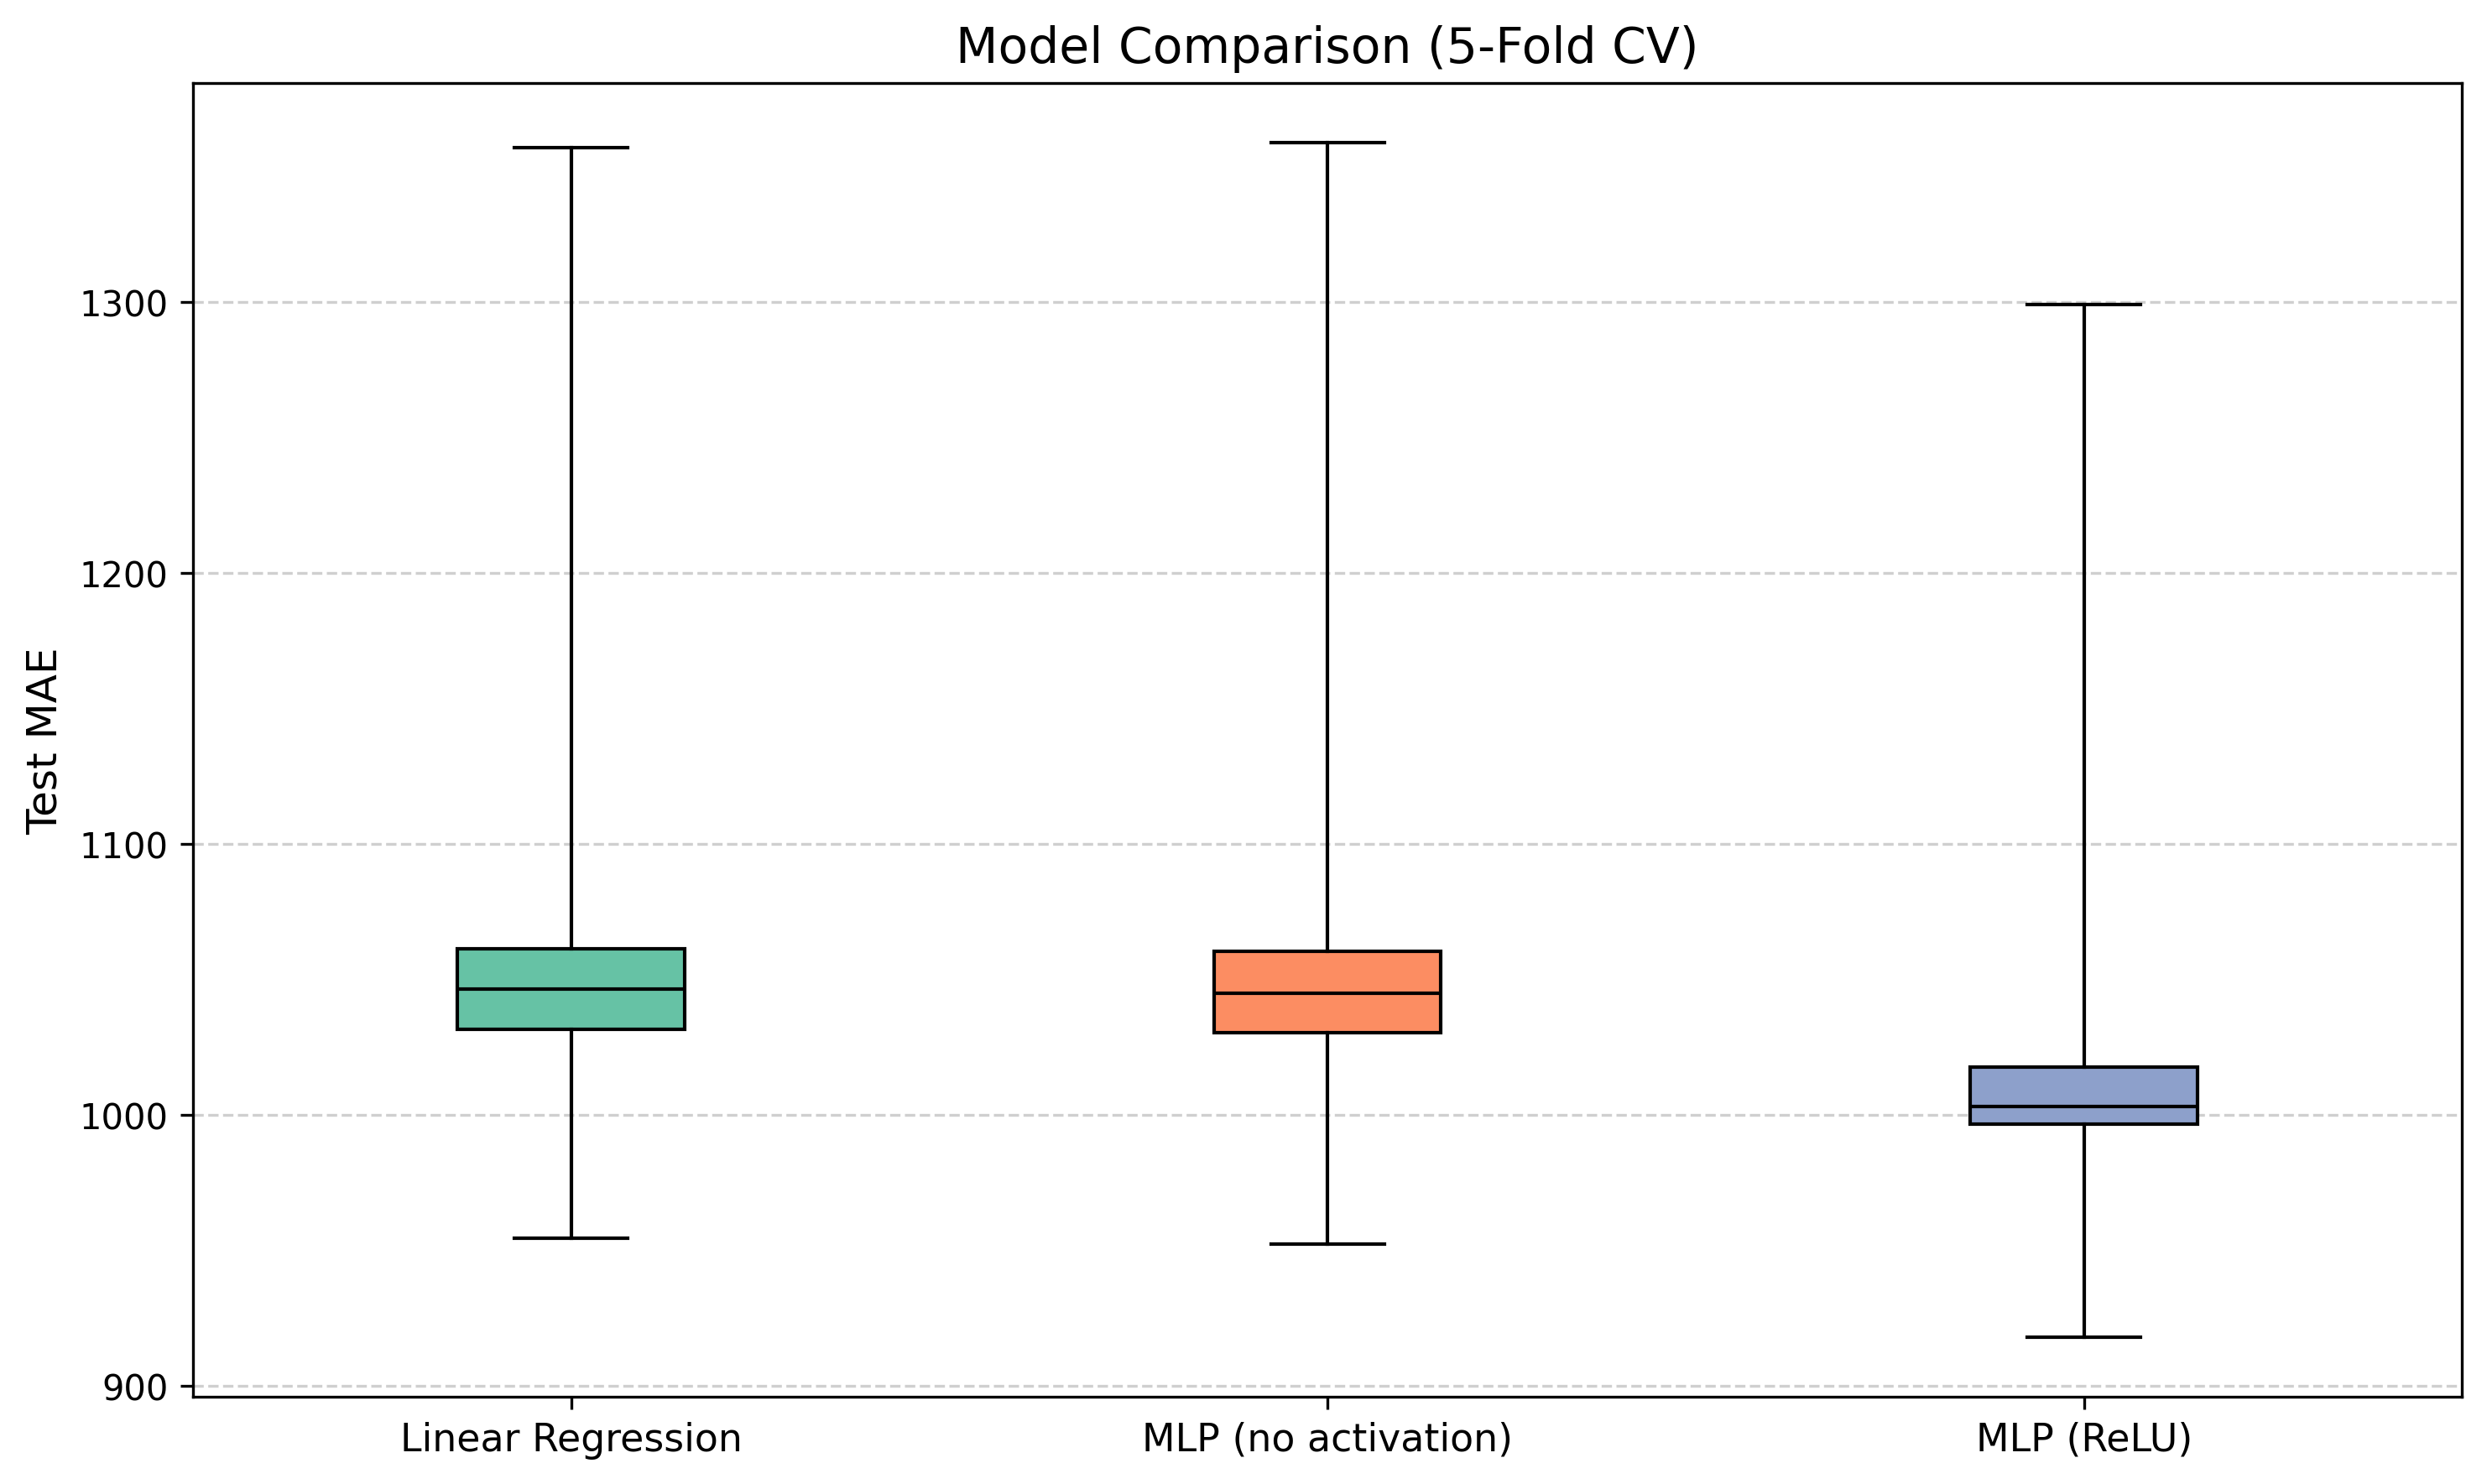

Question 6


While linear regression only captures linear relationships between the features in a dataset,
a multilayer perceptron (MLP) with ReLU activation can model non-linear relationships.
This enables the MLP to identify more complex patterns in the data, potentially improving
pattern recognition and predictive performance.

From the graph, it is evident that there is no difference between the linear regression
model and the MLP without activation, highlighting the importance of incorporating a
non-linear activation function. In contrast, the MLP with ReLU demonstrates lower values across
the maximum, minimum, and overall range of MAE (Median Absolute Error) compared to linear
regression. Additionally, the boxplot and median also indicate reduced MAE values.

Overall, these results suggest that the MLP with ReLU achieves better accuracy than linear regression,
as reflected by the consistently lower MAE.


Question 7

In [ ]:
def loss_curve():
    
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=12)

    mlp_relu = MLPRegressor(hidden_layer_sizes=(5,5),
                            activation='relu',
                            max_iter=1,  # 1 iteração por fit parcial
                            warm_start=True,
                            random_state=12)

    train_loss, val_loss = [], []

    # Treinar manualmente por várias iterações
    # Assim vemos o MAE por cada iteração para ambos val e train
    for i in range(200):
        fold_scaler = StandardScaler()
        x_train_scaled = fold_scaler.fit_transform(x_train)
        x_val_scaled = fold_scaler.transform(x_val)

        #Treino
        mlp_relu.fit(x_train_scaled, y_train)
        #Calculamos ambos o train e val pred para calcular o loss de cada um
        y_train_pred = mlp_relu.predict(x_train_scaled)
        y_val_pred = mlp_relu.predict(x_val_scaled)

        train_loss.append(mean_absolute_error(y_train, y_train_pred))
        val_loss.append(mean_absolute_error(y_val, y_val_pred))

    # Plot das curvas
    iterations = list(range(1, len(train_loss) + 1))
    plt.figure(figsize=(10, 6))
    plt.plot(iterations, train_loss, label="Train MAE", marker='o', markersize=4, linewidth=1)
    plt.plot(iterations, val_loss, label="Validation MAE", marker='o', markersize=4, linewidth=1)
    plt.xlabel("Iteration")
    plt.ylabel("MAE")
    #plt.title("MLP with ReLU – Training and Validation Loss")
    plt.legend()
    plt.tight_layout()
    plt.savefig('loss.png', dpi=300, bbox_inches='tight')
    return None

loss_curve()

Training vs Validation loss graph

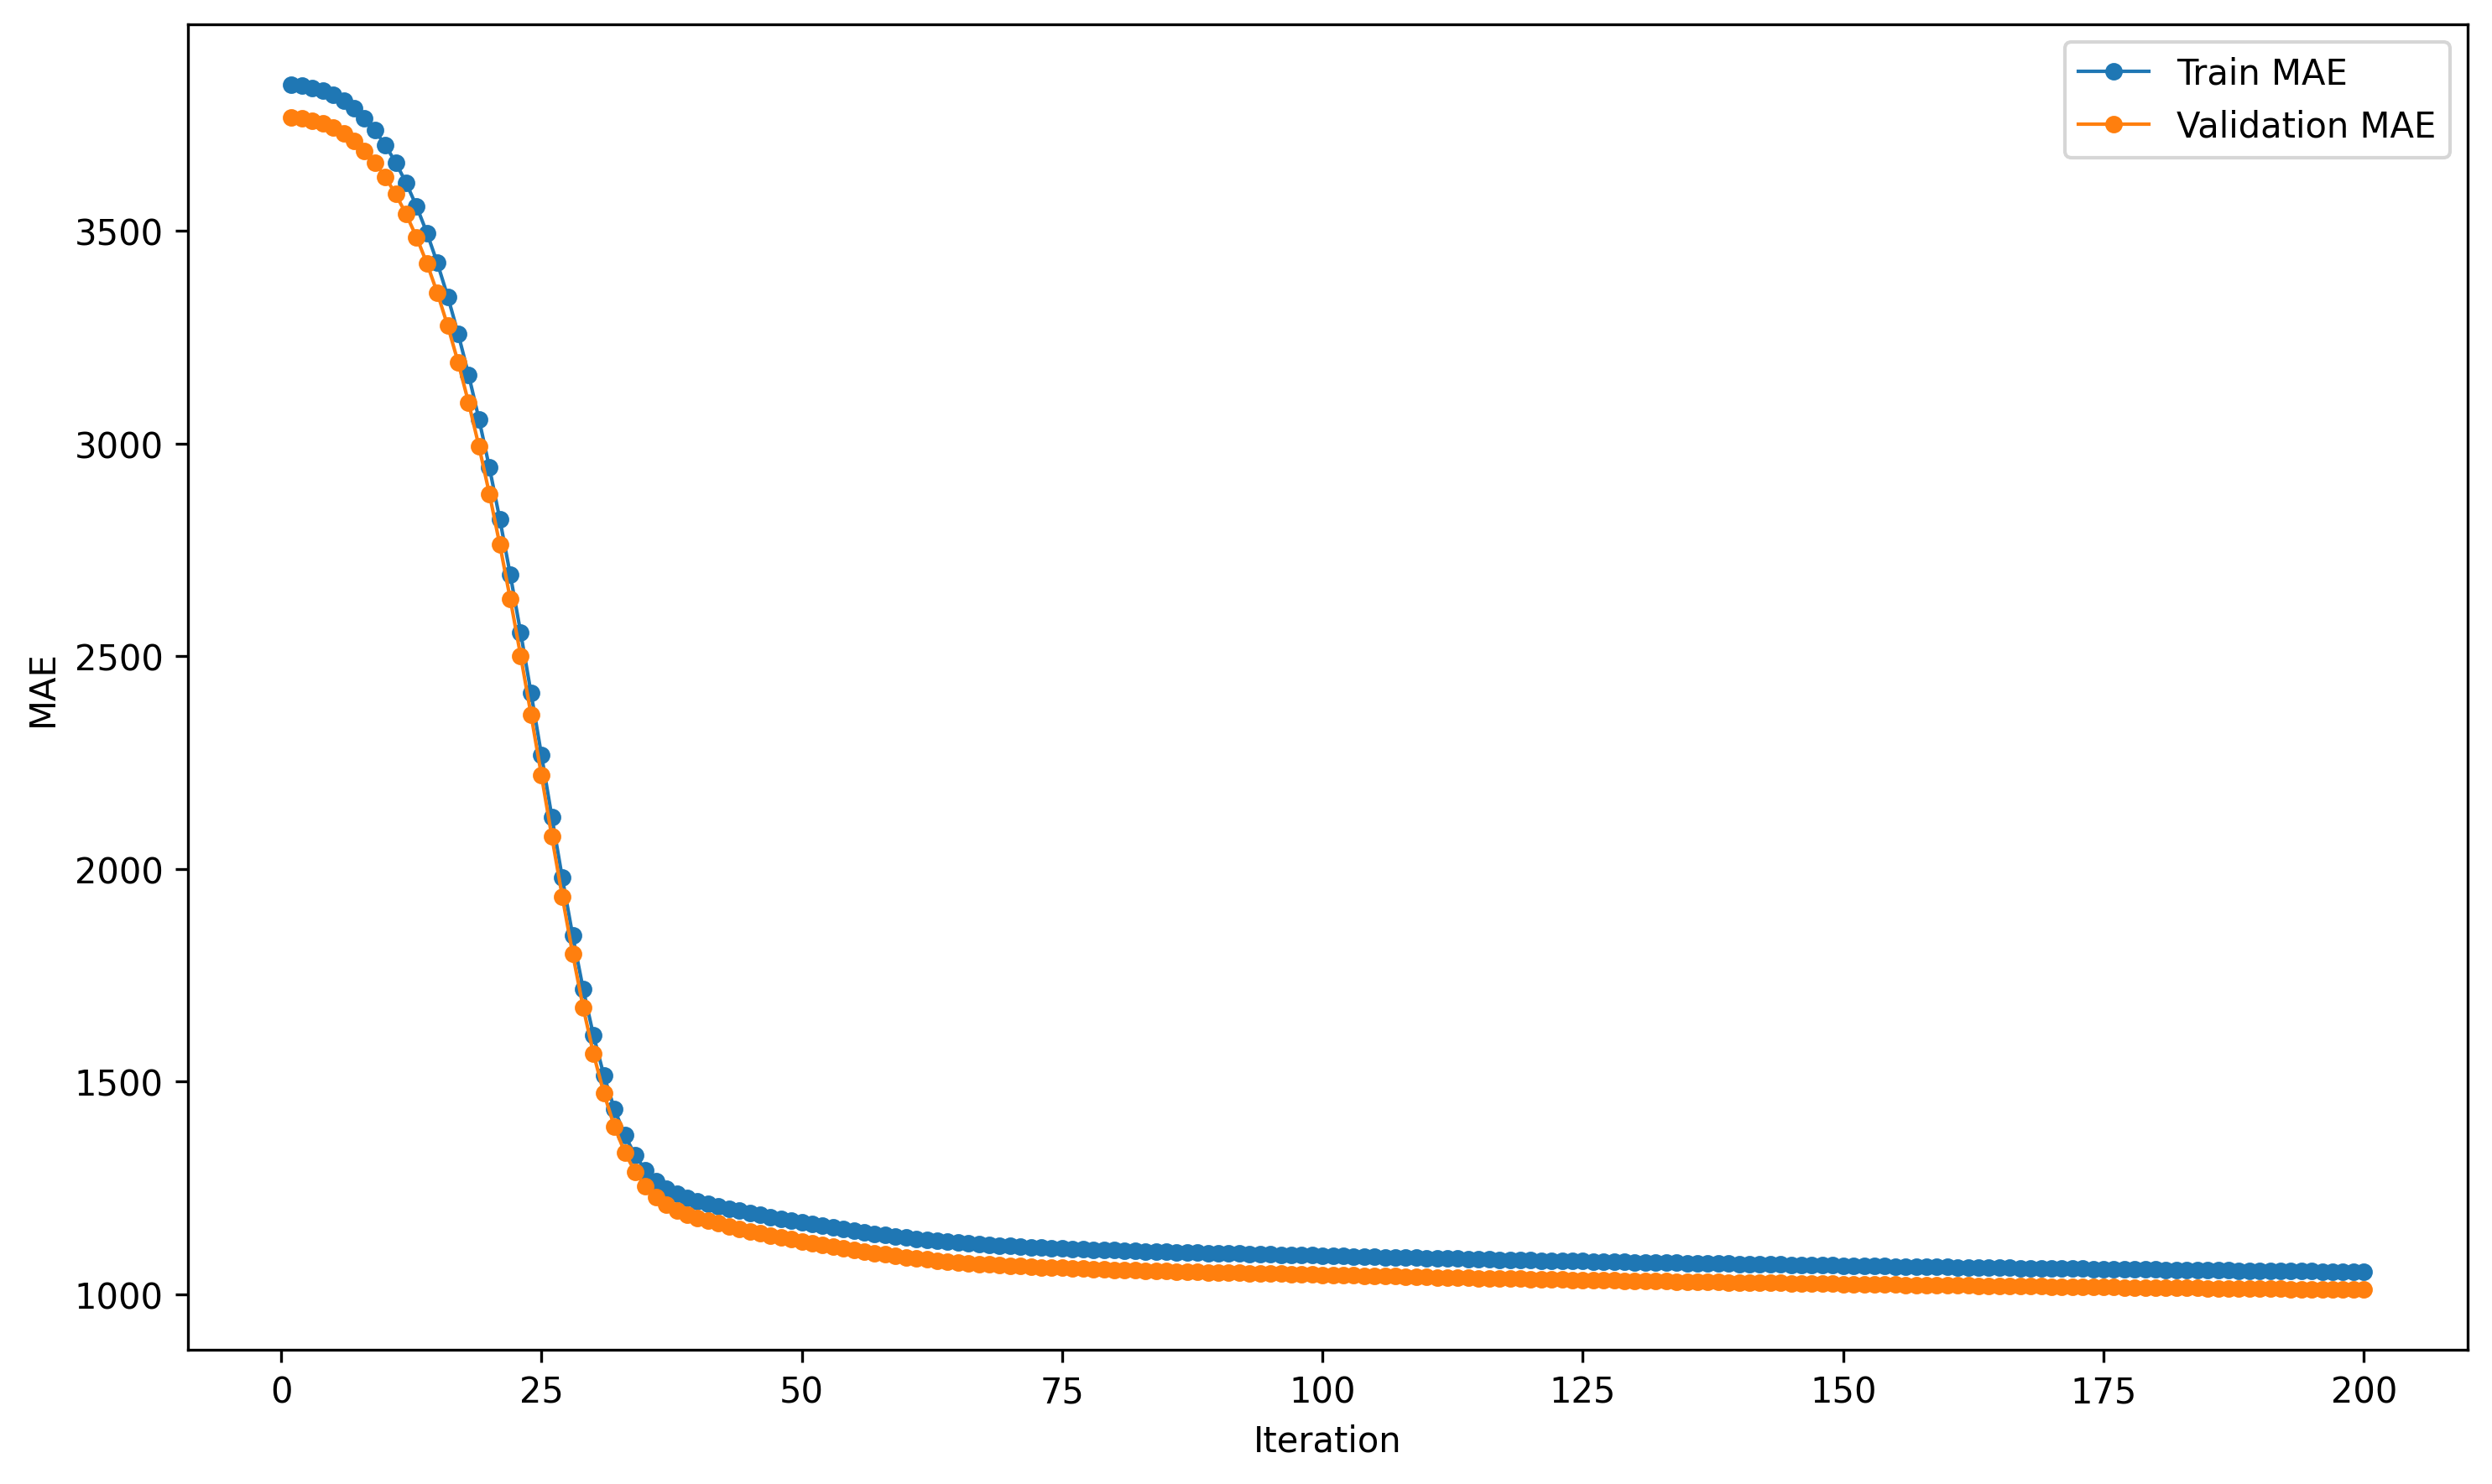

As observed in the graph, as the number of iterations increases, the loss (MAE) for both the
training and validation sets steadily decreases, eventually converging to approximately
1000 MAE. This indicates that the MLP with ReLU activation demonstrates good overall generalization,
effectively learning patterns from the training data while maintaining performance on unseen data.